# hrc_dtfstats

In [1]:
#source /export/ciao/bin/ciao.bash -o
PFILES="./param;$ASCDS_INSTALL/param:$ASCDS_INSTALL/contrib/param"
mkdir -p ./param
ASCDS_WORK_PATH=./


In [2]:
download_chandra_obsid 3698 evt2,dtf
mv -f 3698/primary/*.fits.gz .
gunzip -f *fits.gz
/bin/rm -rf 3698
/bin/ls


  Type     Format      Size  0........H.........1  Download Time Average Rate
  ---------------------------------------------------------------------------
  evt2     fits       40 Mb  ####################          < 1 s  47028.1 kb/s
  dtf      fits       75 Kb  ####################          < 1 s  3901.2 kb/s
  dtf      fits        3 Kb  ####################          < 1 s  294.3 kb/s

      Total download size for ObsId 3698 = 40 Mb
      Total download time for ObsId 3698 = < 1 s

dtcorr_evt2.fits    hrc_dtfstats.sh		 param
dtf.stats	    hrcf03698N006_evt2.fits	 plot.png
filter_evt2.fits    hrcf03698_000N006_dtf1.fits
hrc_dtfstats.ipynb  p1.py


In [3]:
dmkeypar hrcf03698_000N006_dtf1.fits ASCDSVER echo+

10.10


In [4]:
dmcopy "hrcf03698N006_evt2.fits[time=164259750:164261850]" filter_evt2.fits clob+


In [5]:
dmlist hrcf03698N006_evt2.fits  header,clean | egrep '^DTCOR|^ONTIME|^LIVETIME|^EXPOSURE'

ONTIME                    5171.3814679682 [s]       
DTCOR                    0.755343479530             Dead time correction
LIVETIME                  3906.1692719921           Ontime multiplied by DTCOR
EXPOSURE                  3906.1692719921           Total exposure time, with all known corr. appl.


In [6]:
dmlist filter_evt2.fits header,clean | egrep '^DTCOR|^ONTIME|^LIVETIME|^EXPOSURE'

ONTIME                    2100.0 [s]                
DTCOR                    0.755343479530             Dead time correction
LIVETIME                  1586.2213070130           Ontime multiplied by DTCOR
EXPOSURE                  1586.2213070130           Total exposure time, with all known corr. appl.


## Examine dtfs

In [7]:
dmstat "hrcf03698_000N006_dtf1.fits[cols dtf]" 

DTF
    min:	0 	      @:	1 
    max:	1 	      @:	2 
   mean:	0.76564416062 
  sigma:	0.270005164 
    sum:	2081.0208286 
   good:	2718 
   null:	0 



In [8]:
pget dmstat out_mean

0.76564416062


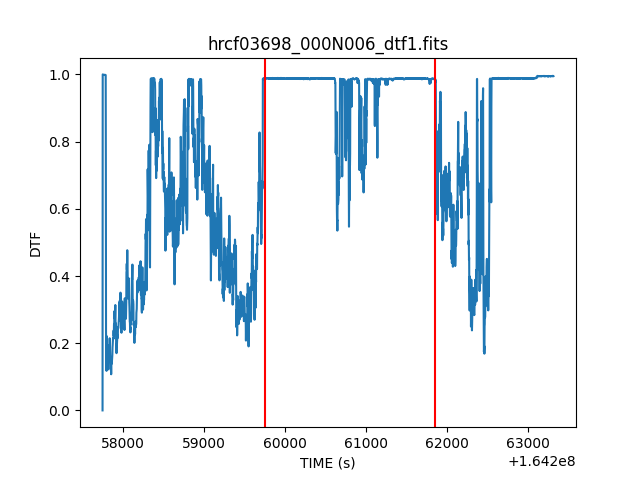

In [9]:
cat << EOM > p1.py
import matplotlib.pylab as plt
from pycrates import read_file

infile="hrcf03698_000N006_dtf1.fits"
tab = read_file(infile)
tt = tab.get_column("time")
dd = tab.get_column("dtf")

xlab = tt.name + (" ({})".format(tt.unit) if len(tt.unit) else "")
ylab = dd.name + (" ({})".format(dd.unit) if len(dd.unit) else "")

plt.plot(tt.values, dd.values)
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.title(infile)
plt.axvline(164259750, color="red")
plt.axvline(164261850, color="red")

plt.savefig("plot.png")
EOM

python p1.py
display < plot.png



## Recompute stats

In [10]:
pset hrc_dtfstats infile=hrcf03698_000N006_dtf1.fits
pset hrc_dtfstats outfile=dtf.stats
pset hrc_dtfstats gtifile=filter_evt2.fits
hrc_dtfstats mode=h clob+

In [11]:
dmlist dtf.stats"[cols DTCOR]" data,clean

#  DTCOR
     0.96380777655308


## Update evt file

In [12]:
dmhedit filter_evt2.fits file= op=add key=DTCOR value=0.963807

### or 

In [13]:
dmkeypar dtf.stats DTCOR
dmhedit filter_evt2.fits file= op=add key=DTCOR value=")dmkeypar.value"

In [14]:
dmkeypar filter_evt2.fits DTCOR echo+

0.96380777655308


## Recompute time keywords

In [15]:
dmcopy filter_evt2.fits"[time=:]" dtcorr_evt2.fits clob+

## Check diffs


In [16]:
dmdiff filter_evt2.fits dtcorr_evt2.fits data=no comments=no || echo 

Infile 1:  filter_evt2.fits
Infile 2:  dtcorr_evt2.fits

----------------------------------------------------------------------
Compare Headers
----------------------------------------------------------------------
Compare Key Lists:
Compare Keyword Details:
Compare Keyword Values:
Keyword: Message:                                                        Value(s):                    Diff:
-------- -------------------------------------- ---------------------------------- ------------------------
CHECKSUM Values are not equal                   UpdhanafUnafanaf  4anP6ZnP4anP4WnP
HISTNUM  Values are not equal                                485  492                        +7 (+1.44%)
LIVETIME Values are not equal                     1586.221307013  2023.9963307615      +437.775 (+27.6%)
EXPOSURE Values are not equal                     1586.221307013  2023.9963307615      +437.775 (+27.6%)

----------------------------------------------------------------------
Compare Subspaces
-------------

# Cleanup


In [17]:
/bin/rm -f hrcf03698N006_evt2.fits hrcf03698_000N006_dtf1.fits